In [160]:
# podstawowe biblioteki
import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,confusion_matrix, roc_auc_score, matthews_corrcoef, plot_roc_curve
from sklearn.model_selection import GridSearchCV

# XGBoost
from xgboost import XGBClassifier

# SHAP
import shap
shap.initjs()

# Wizualizacje
from sklearn.manifold import TSNE
import plotly.express as px
from umap import UMAP

#### 0. Ładowanie Danych

In [4]:
df = pd.read_csv("smartphone_activity_dataset.csv")

In [5]:
attributes = pd.read_csv("attributes_smartphone_activity.csv")

#### 1. Podział zbioru

In [6]:
y = df["activity"]
X = df.drop(['activity'],axis=1)

In [7]:
def split_data(df):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

Zliczanie outlierów

In [9]:
def count_outliers(X : pd.DataFrame, column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((X[column] < (Q1 - 1.5 * IQR)) | (X[column] > (Q3 + 1.5 * IQR))).sum()
    major_outlier_count = ((X[column] < (Q1 - 3 * IQR)) | (X[column] > (Q3 + 3 * IQR))).sum()
    return outlier_count, major_outlier_count

In [88]:
outliers_df = pd.DataFrame(columns=['Column', 'Outliers', 'Major Outliers'])
for column in X_train.columns:
    outlier_count, major_outlier_count = count_outliers(X_train, column)
    outliers_df = outliers_df.append({'Column': column, 'Outliers': outlier_count, 'Major Outliers': major_outlier_count}, ignore_index=True)
outliers_df.sort_values(by='Outliers', ascending=False)

,Column,Outliers,Major Outliers
80,feature_81,2727,2193
120,feature_121,2306,1781
160,feature_161,2189,1429
81,feature_82,2156,1405
161,feature_162,2128,1368
...,...,...,...
523,feature_524,0,0
272,feature_273,0,0
269,feature_270,0,0
15,feature_16,0,0


#### 2. Wybór atrybutów

W tej sekcji zajmiemy się wyborem najlepszych atrybutów. Wykorzystamy do tego funkcję mutual_info_classif to oceny zależności zmiennych opisujących i zmiennej opisywanej.

In [15]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi, index = X_train.columns)

Poniżej przedstawiony jest wykres feature importance dla 10 najlepszych zmiennych (aby zachować czytelność)

Do trenowania modelu wybierzemy 30 najlepszych, po usunięciu zmiennych silnie skorelowanych.

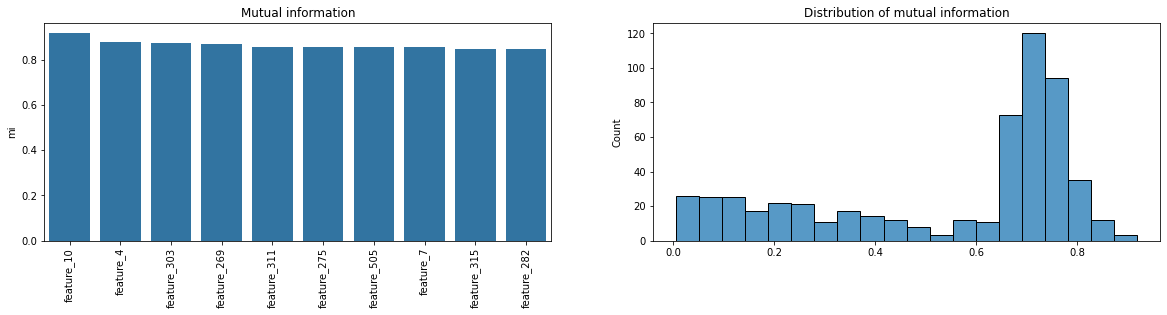

In [450]:
top_10 = mi.sort_values(ascending=False).head(10)
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.barplot(ax=axes[0], x=top_10.index, y=top_10.values, color=sns.color_palette('tab10')[0])
axes[0].set_title("Mutual information")
axes[0].set_ylabel("mi")
axes[0].set_xticklabels(top_10.index, rotation=90)

sns.histplot(ax=axes[1], data=mi.values, bins=20)
axes[1].set_title("Distribution of mutual information")

plt.show()

Usuwanie zmiennych silnie skorelowanych (korelacja Pearsona). Ten zabieg w szczególności jest przydatny do regresji logistycznej, w której występowanie par skorelowanych może zaburzyć pracę modelu.

In [89]:
def remove_highly_correlated(X, mi, threshold=0.65):
    corr_df = X.corr()

    # zmiana formy ramki
    corr_df = corr_df.melt(ignore_index=False).\
        reset_index(drop=False).\
        rename(columns={'index':'Var 1', 'variable': 'Var 2', 'value': 'Corr'})

    # znajdź pary (różnych) zmiennych o korelacji większej niż threshold
    corr_df = corr_df[(np.abs(corr_df['Corr']) > threshold) & (corr_df['Var 1'] != corr_df['Var 2'])].\
        sort_values(by='Corr', ascending=False)

    removed_features = set()
    mi = mi.sort_values()
    correlated_features = set(corr_df['Var 1']).union(set(corr_df['Var 2']))

    # zaczynając od atrybutów najmniej informatywnych (i takich, które są silnie skorelowane)
    # usuwamy je i aktualizujemy zbiór par silnie skorelowanych atrybutów.
    i = 0 
    while corr_df.shape[0] > 0 and i < mi.shape[0]:
        feature = mi.index[i]
        i += 1
        if feature in correlated_features:
            correlated_features.remove(feature)
            removed_features.add(feature)
            corr_df = corr_df[(corr_df['Var 1'] != feature) & (corr_df['Var 2'] != feature)]
    

    return X.drop(list(removed_features), axis=1), list(removed_features)

    

Macierz korelacji przed usunięciem zmiennych skorelowanych

In [115]:
corr_df = X_train.corr()

<AxesSubplot:>

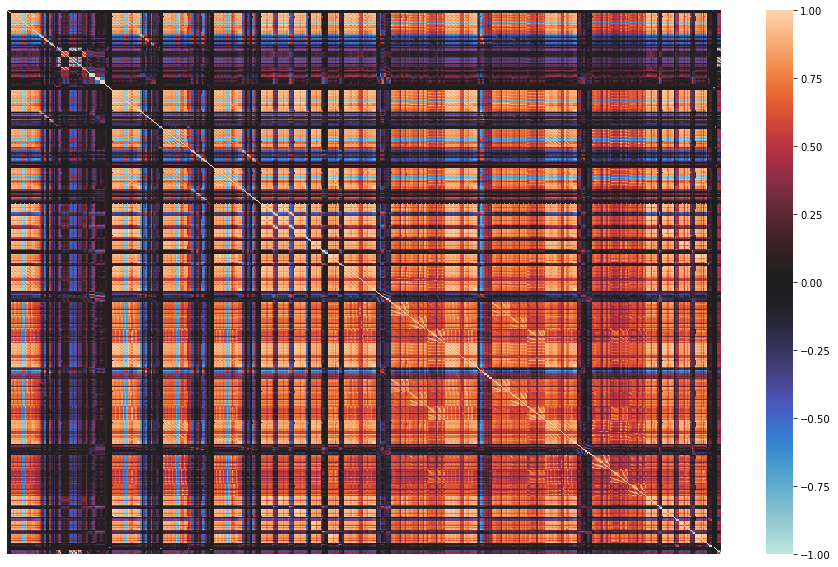

In [121]:
plt.figure(figsize=(16, 10))
sns.heatmap(data=corr_df, vmin=-1, vmax=1, cmap='icefire', xticklabels=False, yticklabels=False)

Jak widać większość zmiennych jest silnie skorelowana z wieloma innymi. Usunięcie ich znacznie zredukuje liczbę atrybutów.

In [122]:
X_train_reduced = remove_highly_correlated(X_train, mi)[0]

In [127]:
print(f"#Attributes originally:\t\t{X_train.shape[1]}\n#Attributes after reduction:\t{X_train_reduced.shape[1]}")

#Attributes originally:		561
#Attributes after reduction:	56


Jak widać usunęliśmy aż 90% wszystkich atrybutów.

In [128]:
corr_df_reduced = X_train_reduced.corr()

<AxesSubplot:>

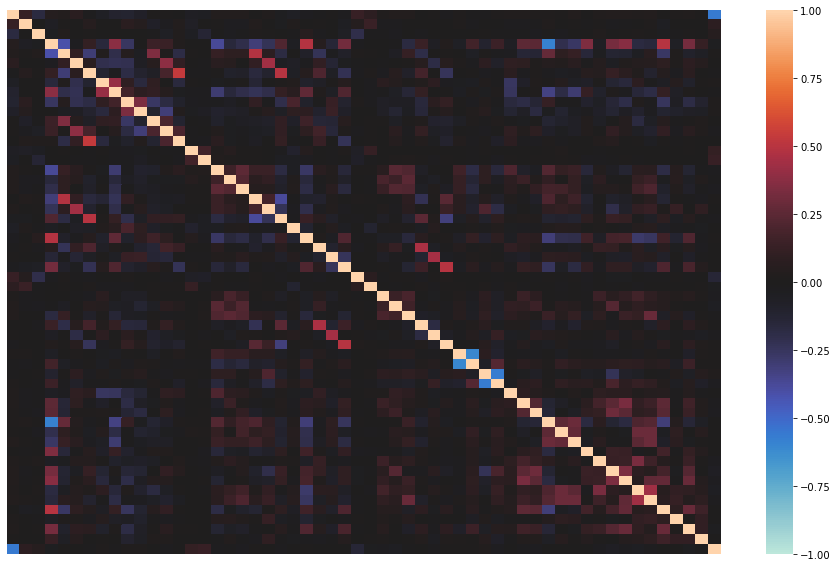

In [129]:
plt.figure(figsize=(16, 10))
sns.heatmap(data=corr_df_reduced, vmin=-1, vmax=1, cmap='icefire', xticklabels=False, yticklabels=False)

Wybór 30 najlepszych atrybutów

In [753]:
KBestSelector = SelectKBest(mutual_info_classif, k=30)
KBestSelector.fit(X_train_reduced, y_train)
cols = KBestSelector.get_support(indices=True)
selected_columns = X_train_reduced.iloc[:,cols].columns.tolist()

Histogramy wybranych zmiennych

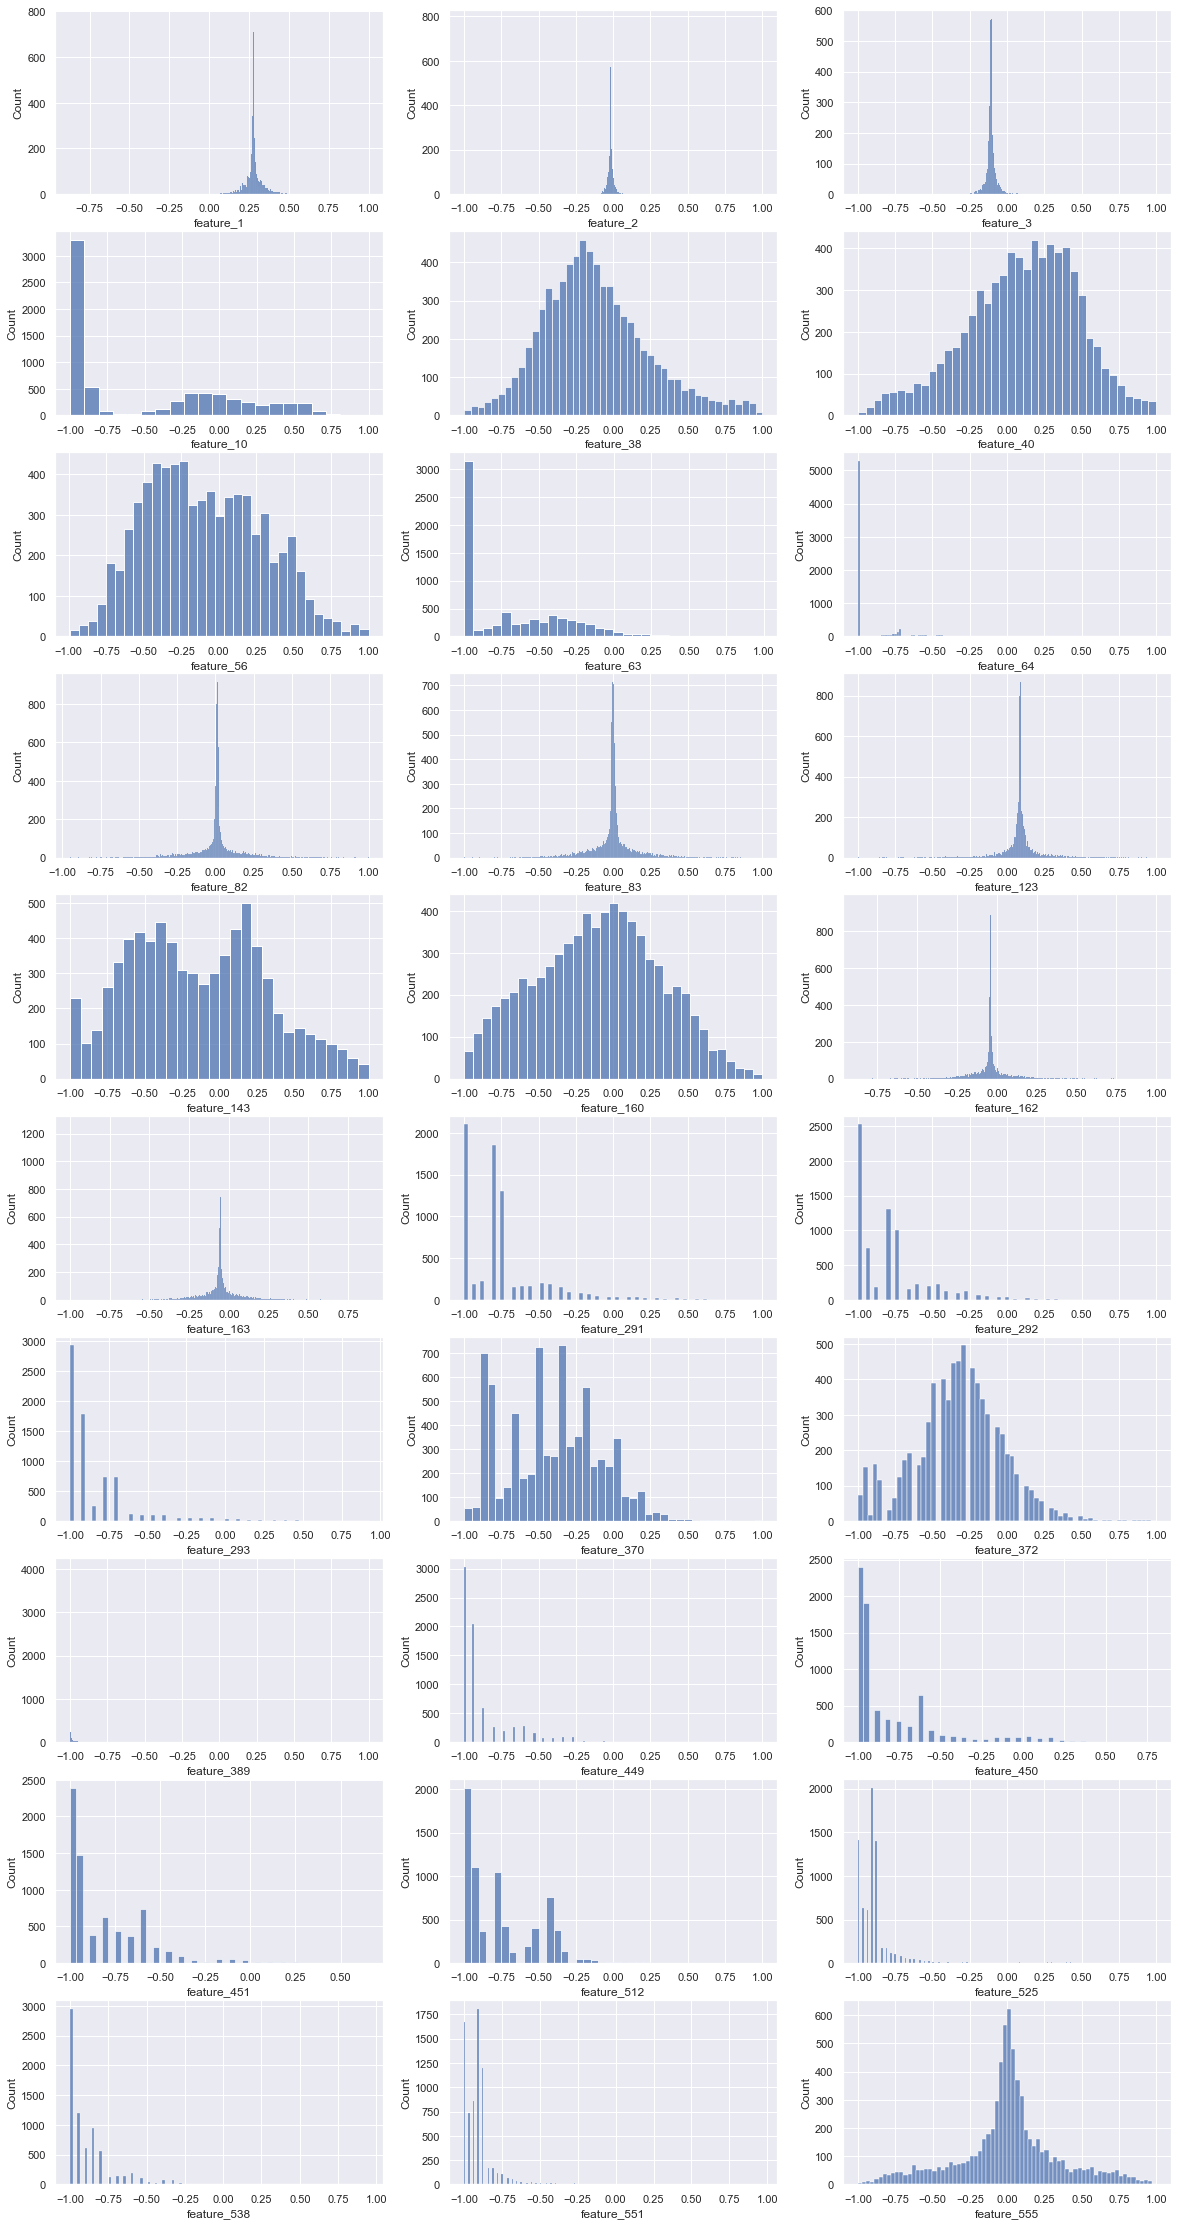

In [744]:
fig, axes = plt.subplots(10, 3, figsize=(20, 40))
for i in range(len(selected_columns)):
    sns.histplot(ax=axes[i // 3, i % 3], data=X_train_reduced, x=selected_columns[i])

Histogram zmiennej celu. Widać, że jest ona rozłożona dość równomiernie między wszystkimi wartościami.

Wartości oznaczają odpowiednio

1. WALKING, 
1. WALKING_UPSTAIRS, 
1. WALKING_DOWNSTAIRS, 
1. SITTING, 
1. STANDING, 
1. LAYING

<AxesSubplot:xlabel='activity', ylabel='Count'>

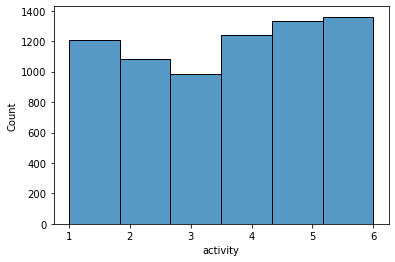

In [71]:
sns.histplot(data=y_train, bins=6)

#### 3. Przygotowanie Modeli

In [747]:
class FeatureSelector:
    def __init__(self, features):
        self.features = features

    def transform(self, X, y=None):
        return X.loc[:,self.features]

    def fit(self, X, y=None):
        return self
    
# do zmiany korelacji ujemnej na dodatnia
class TrendTransformer:
    def __init__(self):
        return None

    def fit(self, X, y = None):
        df = X.copy()
        df['y'] = y
        correlation = df.corr()
        self.neg_corr_columns = df.columns[correlation['y'] < 0]
        return self

    def transform(self, X, y= None):
        X_copy = X.copy()
        for column in self.neg_corr_columns:
            X_copy[column] = -X[column]
        return X_copy
    
# Przycinanie outlierów
class OutlierClamper:
    def __init__(self, min_quantile = 0.025, max_quantile = 0.975):
        self.min_max_dict = {}
        self.min_q = min_quantile
        self.max_q = max_quantile

    def fit(self, X, y = None):
        for column in X.columns:
            if not is_numeric_dtype(X[column]):
                continue
            self.min_max_dict[column] = (X[column].quantile(self.min_q), X[column].quantile(self.max_q))
        return self

    def transform(self, X : pd.DataFrame, y = None):
        X_copy = X.copy()
        for column in X.columns:
            if not is_numeric_dtype(X[column]):
                continue
            min_v = self.min_max_dict[column][0]
            max_v = self.min_max_dict[column][1]
            X_copy.loc[X[column] < min_v, column] = min_v
            X_copy.loc[X[column] > max_v, column] = max_v
        return X_copy

In [755]:
preprocessor = Pipeline(
    steps=[
        ('feat_selector', FeatureSelector(features=selected_columns)),
        ('outlier_clamper', OutlierClamper()),
        ('trend_transformer' , TrendTransformer()),
        ('scaler', StandardScaler())
        ])

In [756]:
rfc = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('random_forest_classifier', RandomForestClassifier(random_state=42, n_estimators=25, max_depth=20))
    ]
)

xgbc = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('xgboost_classifier', XGBClassifier(random_state=42, n_estimators=25, eval_metric='mlogloss'))
    ]
)

logreg = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('logistic_regressor', LogisticRegression(multi_class="multinomial", max_iter=5000))
    ]
)

adb = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('adaboost', AdaBoostClassifier(random_state=42))
    ]
)

#### 4. Ewaluacja Modeli

Funkcja pomocnicza oraz mapa model->score

In [750]:
scores_dict = {}

In [751]:
def evaluate(model : Pipeline, X, y, suppress_output = False):
    y_pred = model.predict(X)
    y_pred_probs = model.predict_proba(X)

    scores = {
        'accuracy': accuracy_score(y,y_pred),
        'precision': precision_score(y,y_pred,average='macro'),
        'recall': recall_score(y,y_pred,average='macro'),
        'f1': f1_score(y,y_pred,average='macro'),
        'roc_auc_score': roc_auc_score(y, y_pred_probs, average="macro", multi_class="ovr"),
        'matthews': matthews_corrcoef(y, y_pred)
    }

    if not suppress_output:
        
        print(f"Accuracy score: ", scores['accuracy'])
        print("precision: ", scores['precision'])
        print("recall: ", scores['recall'])
        print("f1: ", scores['f1'])
        print("AUC: ", scores['roc_auc_score'])
        print("Matthews: ", scores['matthews'])

        sns.heatmap(data = confusion_matrix(y, y_pred), annot=True, fmt='g', xticklabels=np.arange(6), yticklabels=np.arange(6))
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.title("Confusion Matrix")

    return scores

#### Random Forest Classifier

Accuracy score:  0.9472954230235784
precision:  0.9459438078761159
recall:  0.9464865370885329
f1:  0.9461655092953635
AUC:  0.9969854719026779
Matthews:  0.9366211518959744


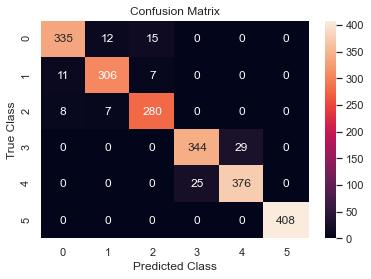

In [757]:
rfc.fit(X_train, y_train)
scores_dict['Random Forest Classifier'] = evaluate(rfc,X_val,y_val)

Widzimy, że model na ogól radzi sobie bardzo dobre. Mamy nieliczne niepoprawne klasyfikacje. Model zdaje się najgorszej radzić przy rozróżnianiu danych opisujących siedzenie (4) i stanie (5).

#### Logistic Regression

Accuracy score:  0.9015256588072122
precision:  0.9005204324450545
recall:  0.9007946379804186
f1:  0.9006479581503655
AUC:  0.9914118984149161
Matthews:  0.8815450625048892


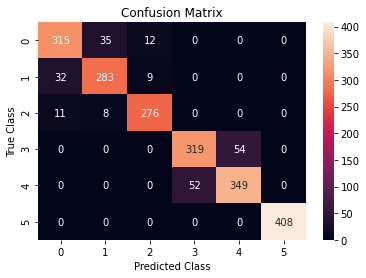

In [202]:
logreg.fit(X_train, y_train)
scores_dict['Logistic Regression'] = evaluate(logreg,X_val,y_val)

Regresja radzi sobie gorzej. W szczególności ponownie pojawia się wcmocniony problem rozróżniania stania i siedzenia, ale tym razem jest także dużo bardziej widoczny problem z rozróżnianiem chodzenia (1) i chodzenia do góry (2)

#### XGBClassifier

Accuracy score:  0.955617198335645
precision:  0.9552118806232871
recall:  0.9554989692710399
f1:  0.9552161619372225
AUC:  0.997380689752234
Matthews:  0.9466660051970602


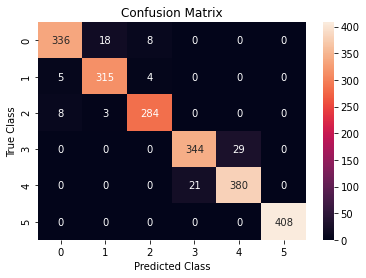

In [203]:
%%capture --no-stdout --no-display
xgbc.fit(X_train, y_train)
scores_dict['XGBClassifier'] = evaluate(xgbc, X_val, y_val)

XGBoost na razie sprawuje się zdecydowanie najlepiej. Dalej ma podobne problemy jak inne modele jednak są one dużo mniej wyraźne.

#### AdaBoost

Accuracy score:  0.5427646786870088
precision:  0.44829546886377414
recall:  0.5013716825006296
f1:  0.37406424847310255
AUC:  0.8740467866907468
Matthews:  0.5035034828863278


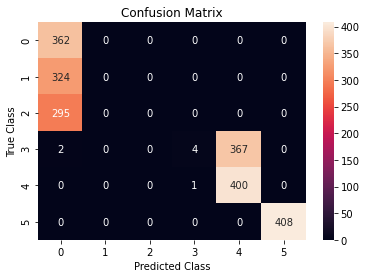

In [204]:
%%capture --no-stdout --no-display
adb.fit(X_train, y_train)
scores_dict['AdaBoost']=evaluate(adb, X_val, y_val)


Możemy zauważyć, że AdaBoost w swojej domyślniej postaci zupełnie sobie nie radzi z predykcjami.

**Wspólna ewaluacja modeli**

In [262]:
def plot_scores(scores_dict : dict, score_names):
    models = pd.Series([k for k, v in scores_dict.items()], name='model')
    score_df = pd.merge(models, pd.Series(score_names, name='score_name'), how='cross')
    
    # To prawdopodobnie da się zrobić lepiej
    score_df['score_value'] = 0
    for i, row in score_df.iterrows():
        score_df.iloc[i, 2] = scores_dict[row['model']][row['score_name']]

    plt.figure(figsize=(15, 6))
    ax = sns.barplot(data = score_df, x = 'model', y='score_value', hue='score_name', dodge=True, palette=sns.color_palette("Set2"))
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.xlabel("classification model")
    plt.ylabel("score value")
    plt.title(f"evaluation of classification models")

    # add hline
    ax.axhline(1, dashes=(3,1), alpha=0.5, color='black')

    # # plot values
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.2%}', (x + width/2, y + height - 0.05), ha='center', fontsize = 8)
    plt.ylim([0, 1.1])
    # plt.show()

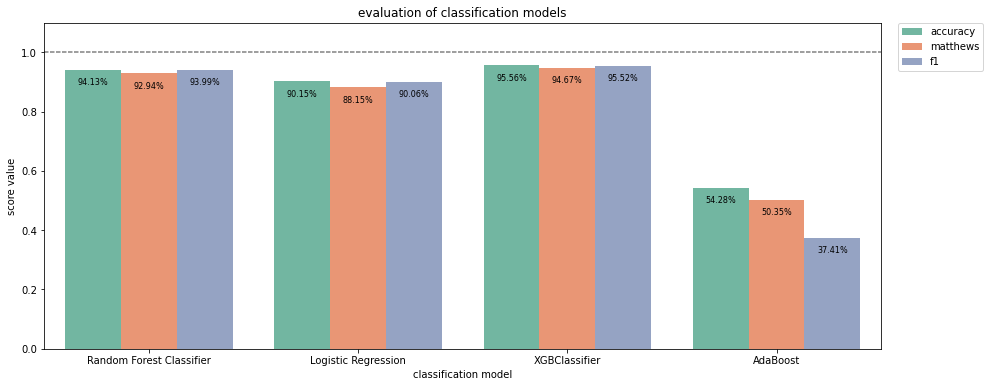

In [265]:
plot_scores(scores_dict, ['accuracy', 'matthews', 'f1'])

Zdecydowanymi zwycięzcami są RFC i XGBC. Regresja logistyczna wypada nieco gorzej jednak najprawdopodobniej jest to spowodowane złym doborem informatywnych atrybutów.

#### 5. Szukanie optymalnych hiperparametrów

Wywołanie GridSearchCV w celu dobrania hiperparametrów

#### Random Forest Classifier

In [284]:
grid = {  
    'min_samples_split': np.logspace(-5, -2, 10),
    'max_depth': np.arange(4, 21, 2)    
}

rfc_grid_search = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('grid_search', GridSearchCV(
            RandomForestClassifier(random_state=42, n_estimators=10),
            param_grid=grid,
            scoring='f1_macro',
            refit=True))
    ]
)

In [ ]:
%%capture --no-stderr
rfc_grid_search.fit(X_train, y_train) 

In [286]:
best_parameters = rfc_grid_search['grid_search'].best_params_  
print(best_parameters) 

{'max_depth': 14, 'min_samples_split': 0.001}


Accuracy score:  0.9422098936662043
precision:  0.9408992567968637
recall:  0.9417565752500271
f1:  0.9412352524239941
AUC:  0.9966947537948281
Matthews:  0.9305279508202103


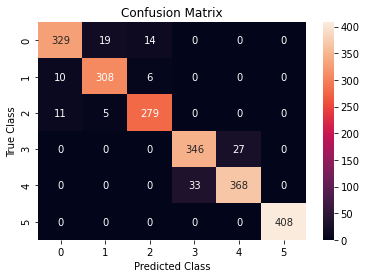

In [287]:
rfc_hyper = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('random_forest_classifier', RandomForestClassifier(random_state=42, n_estimators=25, **best_parameters))
    ]
)

rfc_hyper.fit(X_train, y_train)
scores_dict['Random Forest Classifier (Hyper)'] = evaluate(rfc_hyper, X_val, y_val)

#### Regresja logistyczna

In [375]:
grid = {  
    'max_iter' : np.logspace(1, 3.5, 6),
    'solver' : ['newton-cg', 'sag', 'saga'],
    'penalty' : ['l2', 'none']
}

logreg_grid_search = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('grid_search', GridSearchCV(
            LogisticRegression(random_state=42, penalty='l2', multi_class='multinomial'),
            param_grid=grid,
            scoring='f1_macro',
            refit=True,
            verbose=10))
    ]
)

In [ ]:
%%capture --no-stdout
logreg_grid_search.fit(X_train, y_train)

In [377]:
best_parameters = logreg_grid_search['grid_search'].best_params_  
print(best_parameters) 

{'max_iter': 1000.0, 'penalty': 'none', 'solver': 'sag'}


Accuracy score:  0.912621359223301
precision:  0.9117541686508647
recall:  0.9123968424754175
f1:  0.912029603516569
AUC:  0.9923108719523729
Matthews:  0.8949186023616791


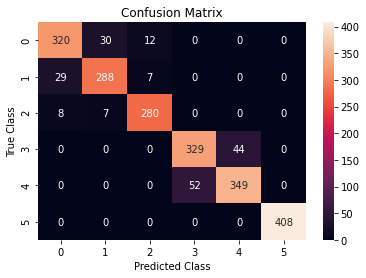

In [378]:
%%capture --no-stdout --no-display
logreg_hyper = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('logistic_regression', LogisticRegression(random_state=42, **best_parameters))
    ]
)

logreg_hyper.fit(X_train, y_train)
scores_dict['Logistic Regression (Hyper)'] = evaluate(logreg_hyper, X_val, y_val)

#### XGBClassifier

In [395]:
grid = {  
    'learning_rate' : np.logspace(-1, -0.1, 12),
    'max_depth' : np.arange(15, 26, 5),
    'gamma': np.logspace(0, 2, 3),
}

xgbc_grid_search = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('grid_search', GridSearchCV(
            XGBClassifier(random_state=42, n_estimators=10, eval_metric='logloss'),
            param_grid=grid,
            scoring='f1_macro',
            refit=True,
            verbose=10))
    ]
)

In [ ]:
%%capture --no-stdout

xgbc_grid_search.fit(X_train, y_train)

In [397]:
best_parameters = xgbc_grid_search['grid_search'].best_params_  
print(best_parameters) 

{'gamma': 1.0, 'learning_rate': 0.373875728896543, 'max_depth': 15}


Accuracy score:  0.9579288025889967
precision:  0.9566583317556737
recall:  0.9568677884324898
f1:  0.956733962300079
AUC:  0.9978711340374152
Matthews:  0.9494022981353163


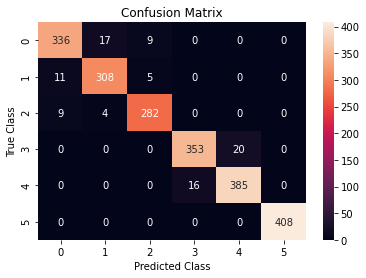

In [398]:
%%capture --no-stdout --no-display
xgbc_hyper = Pipeline(
    steps=[
        ('preproc', preprocessor),
        ('xgbc', XGBClassifier(random_state=42, **best_parameters, eval_metric='logloss'))
    ]
)

xgbc_hyper.fit(X_train, y_train)
scores_dict['XGBClassifier (Hyper)'] = evaluate(xgbc_hyper, X_val, y_val)

In [399]:
scores_table = pd.DataFrame({
    'Model': ['RF','RF','LR', 'LR', 'XGBC', 'XGBC'], 
    'Optimised': ['NO', 'YES'] * 3, 
    'F1 Score': [
        scores_dict['Random Forest Classifier']['f1'],
        scores_dict['Random Forest Classifier (Hyper)']['f1'],
        scores_dict['Logistic Regression']['f1'],
        scores_dict['Logistic Regression (Hyper)']['f1'],
        scores_dict['XGBClassifier']['f1'],
        scores_dict['XGBClassifier (Hyper)']['f1']
    ]})

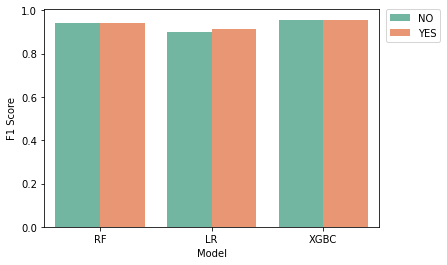

In [401]:
sns.barplot(data=scores_table, x = 'Model', y='F1 Score', hue='Optimised', palette=sns.color_palette("Set2"))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#### 6. Interpretowalność

Interpretowalność za pomocą wbudowanej w bibliokę xgboost funkcji

In [770]:

fi_df = pd.DataFrame(data={'feature_names': selected_columns, 'fi': xgbc_hyper._final_estimator.feature_importances_})
fi_df = pd.merge(fi_df, attributes[['name', 'description']], left_on='feature_names', right_on='name').drop('name', axis=1).sort_values(by='fi')


In [780]:
fig = px.bar(fi_df, 
    y = 'description', 
    x='fi',
    labels=dict(fi="Feature Importance", description="Descrpition")
)
fig.update_layout(
    xaxis_gridcolor='#bbbbbb',
    xaxis_color='white',
    yaxis_color='white',
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(size=8)
)
fig.update_traces(marker_color='#DE3163')
fig.update_yaxes(tickfont=dict(size=8))

Interpretowalność za pomocą shapley values

In [785]:
X_train_processed = preprocessor.fit_transform(X_train, y_train)

In [788]:
explainer = shap.TreeExplainer(xgbc_hyper._final_estimator)
shap_values = explainer.shap_values(X_train_processed)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [796]:
shap.summary_plot(shap_values, X_train)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


#### 7. Wizualizacje

Ta sekcja przeznaczone jest głównie do tworzenie wizualizacji do prezentacji i nie niesie ze sobą żadnej większej wartości merytorycznej

In [570]:
tsne = TSNE(n_components=2, random_state=42)
projections_tsne = tsne.fit_transform(X_train_reduced)

In [687]:
umap_2d = UMAP(random_state=2)
projections_umap = umap_2d.fit_transform(X_train_reduced)

In [678]:
activity_map = {
    1: "WALKING",
    2: "WALKING UP",
    3: "WALKING DOWN",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

simp_activity_map = {
    1: "MOVEMENT",
    2: "MOVEMENT",
    3: "MOVEMENT",
    4: "NO MOVEMENT",
    5: "NO MOVEMENT",
    6: "NO MOVEMENT"
}

col_seq = [
    "#DE3163", # walking
    "#096182", #laying
    "#FFBF00", # walking up
    "#24aae2", #staying
    "#FF7F50", # walking down
    "#0e8c7f", #sitting
]

**tSNE, UMAP** -- Wizualizacja za pomocą projekcji na płaszczyznę

In [688]:
fig = px.scatter(
    projections_umap, x=0, y=1,
    color=y_train.map(activity_map), labels={'color': 'Activity'},
    color_discrete_sequence=col_seq,
    width=1000, height=600,
    opacity=0.6,
)
fig.update_xaxes(showgrid=False, visible=False)
fig.update_yaxes(showgrid=False, visible=False)
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)', 
    legend_font_color="white",
    legend=dict(
        yanchor="middle",
        y=0.5,
        xanchor="right",
        x=1.2,
        font=dict(size = 12))
    )
fig.show()

**Macierz konfuzji**

In [ ]:
y_pred = xgbc_hyper.predict(X_val)
cf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(20, 20))
sns.set(font_scale=3)
fig = sns.heatmap(data = cf_matrix, 
    annot=True, 
    fmt='g', 
    xticklabels=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING","LAYING"], 
    yticklabels=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING","LAYING"], 
    linewidths=.5,
    cbar=False)
plt.tick_params(axis='both', colors='white', rotation=45)
plt.xlabel("Predicted", dict(color = 'white', size=70, weight='bold'))
plt.ylabel("True", dict(color = 'white', size=70, weight='bold'))
plt.savefig('cfm.png', transparent=True, bbox_inches='tight')

Metryki dla XGBClassifier

In [677]:
xgbc_score_df = pd.DataFrame(data={'Score Type': ['Precision', 'Recall', 'F1 Score'], 
            'Value': [
                scores_dict['XGBClassifier (Hyper)']['precision'], 
                scores_dict['XGBClassifier (Hyper)']['recall'], 
                scores_dict['XGBClassifier (Hyper)']['f1']
                ]
            })
fig = px.bar(xgbc_score_df, x = 'Score Type', y='Value',
        width = 800,
        height = 600,
        )

fig.update_layout(
    yaxis_range=[0.95,0.961],
    yaxis_gridcolor='#bbbbbb',
    yaxis_color='white',
    xaxis_color='white',
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(size=20)
    )
fig.update_traces(marker_color='#DE3163')
fig.show()


Porównanie wyników dla różnych modeli

In [715]:
models = pd.Series([k for k, v in scores_dict.items()], name='Model')
score_df = pd.merge(models, pd.Series(['f1', 'matthews', 'roc_auc_score'], name='Score Name'), how='cross')

score_df['Score Value'] = 0
for i, row in score_df.iterrows():
    score_df.iloc[i, 2] = scores_dict[row['Model']][row['Score Name']]

In [ ]:
score_df = score_df[~score_df.Model.str.contains('(Hyper)')]

In [731]:
fig = px.bar(score_df, 
    x='Model', y='Score Value',
    text='Score Value',
    color='Score Name',
    color_discrete_sequence=col_seq,
    barmode='group')

fig.update_layout(
    yaxis_range=[0,1.1],
    yaxis_gridcolor='#bbbbbb',
    yaxis_color='white',
    xaxis_color='white',
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(size=12),
    legend_font_color="white",
    legend=dict(
        yanchor="middle",
        y=0.5,
        xanchor="right",
        x=1.2,
        font=dict(size = 12))
    )
fig.update_traces(textposition='inside', textfont_size=14, texttemplate='%{text:0.3f}')
fig.show()